# Discrete gamma hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

In our experiment we want to hedge a portfolio composed by an European call options that at time $T$ pays $X = (S(T) - K_1)^+$ where $K_1 > 0$ is the strike price. The pricing function of this call options is denoted with $F(t, s)$.

Since we cannot gamma hedge the call options with the underlying itself (the gamma of the underlying is zero) we are going to introduce another derivative in our hedging portfolio. For this purpose I've chosen a call options that at time $T_1 > T$ pays $Y = (S(T) - K_2)$, where $K_2 > K_1$ is the strike price of this options. The pricing function of this call options is denoted with $G(t, s)$. 

The experiment will be performed with the following parameters:
$$
S(0) = 100 \\
\mu = 0.0 \\
\sigma = 0.2 \\
K_1 = 110 \\
K_2 = 120 \\
T = 1.0 \\
T_1 = 1.1 \\
r = 0.0 
$$

Furthermore, no transaction costs will be assumed.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print('Adding module')
    sys.path.append(module_path)

Adding module


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european, gamma_european

In [3]:
seed = 0

In [4]:
s0 = 100
sigma = 0.2
mean = 0.0
maturity = 1.0
maturity_1 = 1.1
N = 252
dt = maturity / N
n_sim = 1
K_1 = 110
K_2 = 120
discount_rate = 0.0
dtype = jnp.float32

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)

In [5]:
stock_path = gmb.simulate_paths(seed, maturity, N, n_sim)

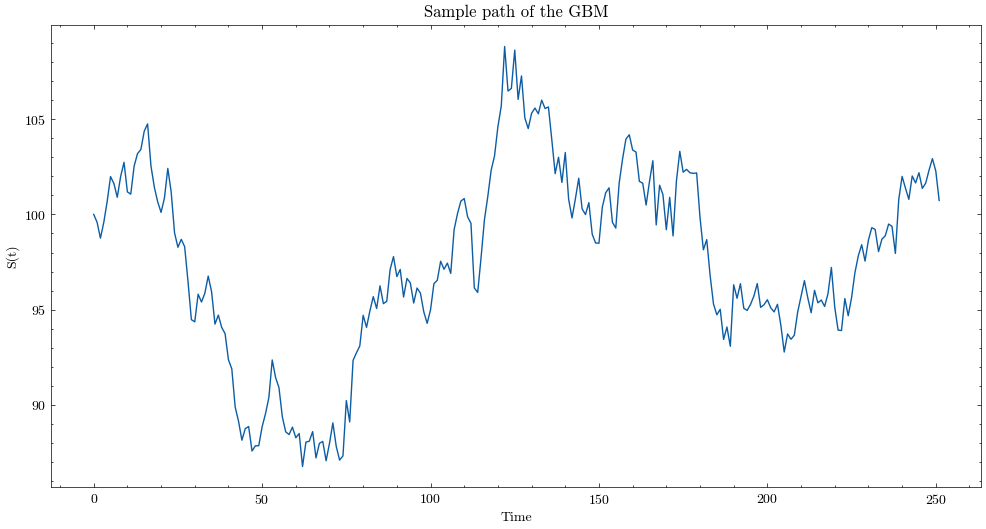

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path)
plt.title('Sample path of the GBM')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.show()

## Hedging experiment code

The gamma hedging will be done in the following way (Bjork, ed 4th, Cp.10.3)

At the begging
$$
V(0) = C(0, S(0); K, T, \sigma, r) = x_G(0) \cdot G(0,S(0)) + x_s(0) \cdot S(0) + (\text{bank account})
$$

Then:

$$
V = x_G \cdot G(t,s) + x_s \cdot s + (\text{bank account})
$$

where 

- $x_G = \frac{\Gamma_F}{\Gamma_G}$
- $x_s = \frac{\Delta_G \Gamma_F}{\Gamma_G} - \Delta_F$
- the rest is put in the bank account

The performance of the hedging strategy are measure both comparing the price of the hedging portfolio and the price of the portfolio to hedge during the experiment. And also by comparing the payoff of the derivative and the value of the hedging portfolio at the end.

In [7]:
gammas_f = [gamma_european(stock_path[0], K_1, maturity - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
gammas_g = [gamma_european(stock_path[0], K_2, maturity_1 - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
x_g = [gammas_f[i] / gammas_g[i] for i in range(0, N)]
deltas_f = [delta_european(stock_path[0], K_1, maturity - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
deltas_g = [delta_european(stock_path[0], K_2, maturity_1 - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
x_s = [-((deltas_g[i] * gammas_f[i] / gammas_g[i]) - deltas_f[i]) for i in range(0, N)]
p_call_price = [european_price(stock_path[i], K_1, maturity - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
h_call_price = [european_price(stock_path[i], K_2, maturity_1 - (i * dt), sigma, discount_rate, dtype=dtype) for i in range(0, N)]
bank_account = [p_call_price[0] - (x_g[0] * h_call_price[0] + x_s[0] * stock_path[0])]
vs = [p_call_price[0]]

for i in range(1, N):
    vs.append(x_g[i - 1] * h_call_price[i] + x_s[i - 1] * stock_path[i] + bank_account[i - 1])
    bank_account.append(vs[i] - (x_g[i] * h_call_price[i] + x_s[i] * stock_path[i]))

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path - K_1, 0)

In [8]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  [0.02256009]


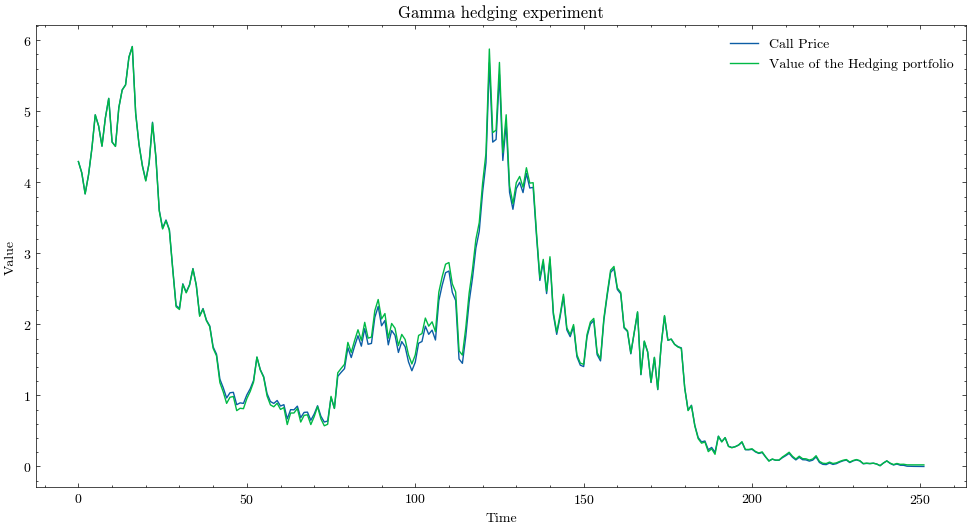

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(p_call_price, label='Call Price')
plt.plot(vs, label='Value of the Hedging portfolio')
plt.legend()
plt.title('Gamma hedging experiment')
plt.xlabel('Time')
plt.ylabel('Value')

plt.show()